# Case Study 5.2 - Feature Importance

In the second case study we look at methods for understanding how semantic vectors contribute to model predictions.

The original scripts for the content of this Notebook can be found here:

* [Tree & Permutation - CaseStudy_5.2_01-01.py](CaseStudy_5.2_01-01.py)
* [Ablation Experiment - CaseStudy_5.2_01-02.py](CaseStudy_5.2_01-02.py)
* [Plot Results - CaseStudy_5.2_01-03.py](CaseStudy_5.2_01-03.py)

**NOTE** For this Case Study we need to copy the serialised model saved in Chapter 4. The file `xt_BERT_model.pkl` should be copied into this directory, or simply change the file path to whereever that file was saved.

## 01 - Tree and Permutation Importance Metrics

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import permutation_importance

In [ ]:
df = pd.read_csv("data/complete_with_features.csv")
embeddings = "Embeddings_bert-base-uncased.npy"

In [ ]:
def expand_array_col(df, col_name):
    expanded = df[col_name].apply(pd.Series)
    expanded.columns = [f'{col_name}_{i+1}' for i in range(expanded.shape[1])]
    df_expanded = pd.concat([df.drop(col_name, axis=1), expanded], axis=1)
    return df_expanded, expanded.columns

embs = np.load(embeddings, allow_pickle=True,)
df["embedding"] = list(embs)
newdf, cols = expand_array_col(df, "embedding")

In [ ]:
test = newdf[newdf["RANDOM"]>=0.8]
X_test = test.loc[:,cols]
y_test = test.loc[:,"generated"]

In [ ]:
tree_imps = xt_model.feature_importances_

result = permutation_importance(xt_model, X_test, y_test, n_repeats=10, random_state=42)
perm_imps =result.importances_mean

## 02 - Ablation Experiment

In the next part we repeatedly retrain our modeling leaving features out to understand their importance.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
df = pd.read_csv("data/complete_with_features.csv")
embeddings = "Embeddings_bert-base-uncased.npy"

In [ ]:
def expand_array_col(df, col_name):
    expanded = df[col_name].apply(pd.Series)
    expanded.columns = [f'{col_name}_{i+1}' for i in range(expanded.shape[1])]
    df_expanded = pd.concat([df.drop(col_name, axis=1), expanded], axis=1)
    return df_expanded, expanded.columns

embs = np.load(embeddings, allow_pickle=True,)
df["embedding"] = list(embs)
newdf, cols = expand_array_col(df, "embedding")

In [ ]:
train = newdf[newdf["RANDOM"]<0.8]
test = newdf[newdf["RANDOM"]>=0.8]
X_train = train.loc[:,cols]
y_train = train.loc[:,"generated"]
X_test = test.loc[:,cols]
y_test = test.loc[:,"generated"]

In [ ]:
xt = ExtraTreesClassifier()
xt.fit(X_train, y_train)

# Baseline Metrics for the Extra Trees Model
scores = xt.predict_proba(X_test)
baseline = roc_auc_score(y_test, scores[:,1])

In [ ]:
diffs = []

for col in cols:
    temp_cols = [x for x in cols if x!=col]
    X_train = train.loc[:,temp_cols]
    X_test = test.loc[:,temp_cols]
    xt = ExtraTreesClassifier()
    xt.fit(X_train, y_train)
    scores = xt.predict_proba(X_test)
    auc = roc_auc_score(y_test, scores[:,1])
    diff = baseline - auc
    diffs.append(diff)

In [ ]:
results = pd.DataFrame(
   {
      "feature":cols,
      "permutation":perm_imps,
      "tree":tree_imps,
      "ablation":diffs
   }
)

results.to_csv("data/feature_importance.csv", index=False)

## 03 - Plot Results

Plot each of the three methods against the other two to understand the correlation between them.

In [ ]:
import matplotlib.pyplot as plt

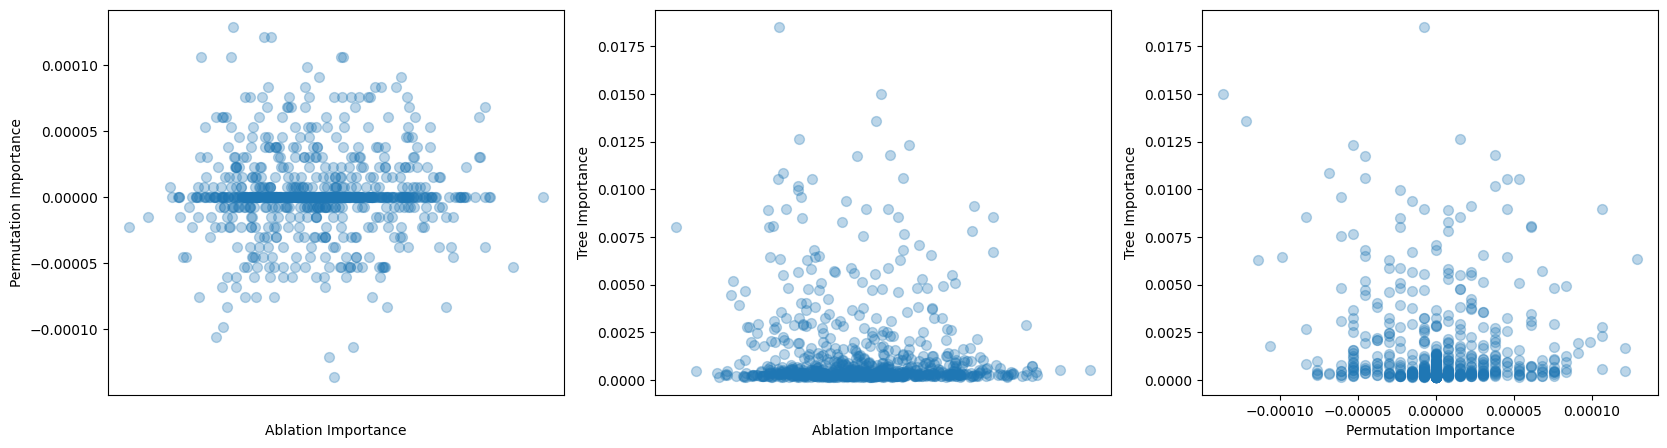

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].scatter(results['ablation'], results['permutation'], alpha=0.3, s=50)
axes[0].set_xlabel('Ablation Importance')
axes[0].set_ylabel('Permutation Importance')
xticks = axes[0].xaxis.get_major_ticks()

xticks[1].set_visible(False)
xticks[2].set_visible(False)
xticks[3].set_visible(False)
xticks[4].set_visible(False)
xticks[5].set_visible(False)

axes[1].scatter(results['ablation'], results['tree'], alpha=0.3, s=50)
axes[1].set_xlabel('Ablation Importance')
axes[1].set_ylabel('Tree Importance')

xticks = axes[1].xaxis.get_major_ticks()
xticks[1].set_visible(False)
xticks[2].set_visible(False)
xticks[3].set_visible(False)
xticks[4].set_visible(False)
xticks[5].set_visible(False)

axes[2].scatter(results['permutation'], results['tree'], alpha=0.3, s=50)
axes[2].set_xlabel('Permutation Importance')
axes[2].set_ylabel('Tree Importance')
plt.show()